<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>
<a target="_blank" href="https://colab.research.google.com/drive/1hl2PgO_41IBgFnUY74JwUJPuvplKWgkI#scrollTo=14x75mB7VTP9">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Moving Gas Stations away from Schools in Seattle en WA, USA

# Getting ready

## Installations needed

In [ ]:
!pip install osmnx mapclassify

## Data needed

### Official data preprocessing

Paso 1: Importar la librería creada en GitHub



In [ ]:
import geopandas as gpd

filez="https://github.com/Camila-Ramirez-Datos-espaciales/Evaluacion-Individual2/raw/refs/heads/main/2020_Census_Tracts_Seattle_8661193084158732132.zip"
seattle=gpd.read_file(filez)
seattle.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID20     177 non-null    object  
 1   GROSS_ACRE  177 non-null    float64 
 2   LAND_ACRES  177 non-null    float64 
 3   WATER_ACRE  177 non-null    float64 
 4   NAME        177 non-null    object  
 5   TRACT_NUMB  177 non-null    int64   
 6   BASENAME    177 non-null    object  
 7   UVDA_AREA   177 non-null    object  
 8   CRA_NO      177 non-null    float64 
 9   CRA_GRP     177 non-null    int32   
 10  GEN_ALIAS   177 non-null    object  
 11  DETL_NAMES  177 non-null    object  
 12  C_DISTRICT  177 non-null    int64   
 13  geometry    177 non-null    geometry
dtypes: float64(4), geometry(1), int32(1), int64(2), object(6)
memory usage: 18.8+ KB


**PASO 1:** Disolver los limites censales, solo necesitamos los limites de Seattle.

In [ ]:
seattle_dissolved = seattle.dissolve(by=None, as_index=False)

In [ ]:
seattle_dissolved

index                                           geometry      GEOID20  \
0      0  MULTIPOLYGON (((1260535.89 188253.83, 1260523....  53033000402   

   GROSS_ACRE  LAND_ACRES  WATER_ACRE               NAME  TRACT_NUMB BASENAME  \
0  444.493643  444.527261         0.0  Census Tract 4.02         402     4.02   

             UVDA_AREA  CRA_NO  CRA_GRP              GEN_ALIAS  \
0  Bitter Lake Village     9.1        9  Broadview/Bitter Lake   

               DETL_NAMES  C_DISTRICT  
0  Broadview, Bitter Lake           5

Limpiar y ordenar código

In [ ]:
seattle= gpd.GeoDataFrame(
    {'CITY': ['Seattle'],
     'STATE': ['Washington']},
    geometry=seattle_dissolved.geometry,
    crs=seattle_dissolved.crs
)
display(seattle)

CITY       STATE                                           geometry
0  Seattle  Washington  MULTIPOLYGON (((1260535.89 188253.83, 1260523....

El mapa que tenemos viene proyectado

In [ ]:
seattle.crs

<Projected CRS: PROJCS["NAD83(HARN) / Washington North (ftUS)",GEO ...>
Name: NAD83(HARN) / Washington North (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Crowdsourced data pre processing

**PASO 2:** Obtener los centros educativos de Seattle.

In [ ]:
# Get schools in Seattle
schools = ox.features_from_place("Seattle, WA, USA",
                                tags={'amenity': 'school'})
schools.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 210 entries, ('node', np.int64(356540545)) to ('way', np.int64(1442890189))
Data columns (total 67 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geometry                 210 non-null    geometry
 1   amenity                  210 non-null    object  
 2   check_date               20 non-null     object  
 3   ele                      139 non-null    object  
 4   gnis:feature_id          145 non-null    object  
 5   name                     210 non-null    object  
 6   addr:city                146 non-null    object  
 7   addr:housenumber         156 non-null    object  
 8   addr:postcode            145 non-null    object  
 9   addr:street              156 non-null    object  
 10  religion                 24 non-null     object  
 11  addr:state               105 non-null    object  
 12  old_name                 11 non-null     object  
 13  web

In [ ]:
schools.reset_index(inplace=True)
schoolSeattle=schools[['element','name','geometry']].copy()
schoolSeattle.fillna({'name':'Unknown'},inplace=True)
schoolSeattle['newname']=schoolSeattle.index.astype(str)+"_"+schoolSeattle.name
schoolSeattle.set_index('newname',inplace=True)
schoolSeattle.drop(columns=['name'],inplace=True)
schoolSeattle = schoolSeattle.to_crs(Seattle_crs)
schoolSeattle.head()


element                          geometry
newname                                                                      
0_Mapleleaf School                     node  POINT (-3407964.905 2602797.259)
1_Hazel Wolf K-8                       node  POINT (-3411201.026 2601737.039)
2_Epic Life Academy                    node    POINT (-3410651.7 2605152.512)
3_Christ the King Elementary School    node  POINT (-3410862.072 2606402.301)
4_Assumption Saint Bridget School      node  POINT (-3409548.844 2600245.575)

Veremos los diferentes elementos: node, element y way

In [ ]:
pd.crosstab(schoolSeattle.element,schoolSeattle.geometry.geom_type, margins=True)

col_0     MultiPolygon  Point  Polygon  All
element                                    
node                 0     54        0   54
relation             4      0        2    6
way                  0      0      150  150
All                  4     54      152  210

In [ ]:
#original data
schools[(schools.element=='relation') & (schools.geometry.geom_type=='MultiPolygon')]

element        id                                           geometry  \
54  relation    537423  MULTIPOLYGON (((-122.2931 47.57649, -122.29298...   
56  relation   4764405  MULTIPOLYGON (((-122.31777 47.64223, -122.3176...   
57  relation   7616973  MULTIPOLYGON (((-122.33765 47.69496, -122.3376...   
59  relation  18609000  MULTIPOLYGON (((-122.26364 47.67391, -122.2636...   

   amenity check_date  ele gnis:feature_id                          name  \
54  school        NaN   28         1505026          Franklin High School   
56  school        NaN   62         1515690    Seattle Preparatory School   
57  school        NaN  NaN             NaN    Cascadia Elementary School   
59  school        NaN  NaN             NaN  Sand Point Elementary School   

   addr:city addr:housenumber  ... access:disabled not:name school  \
54       NaN              NaN  ...             NaN      NaN    NaN   
56   Seattle             2400  ...             NaN      NaN    NaN   
57   Seattle             1700  ...             NaN      NaN    NaN   
59   Seattle             6208  ...             NaN      NaN    NaN   

   school:type building:levels  fax name:etymology addr:housename layer  \
54         NaN             NaN  NaN            NaN            NaN   NaN   
56         NaN             NaN  NaN            NaN            NaN   NaN   
57         NaN             NaN  NaN            NaN            NaN   NaN   
59         NaN             NaN  NaN            NaN            NaN   NaN   

            type  
54  multipolygon  
56  multipolygon  
57  multipolygon  
59  multipolygon  

[4 rows x 69 columns]

<Axes: >

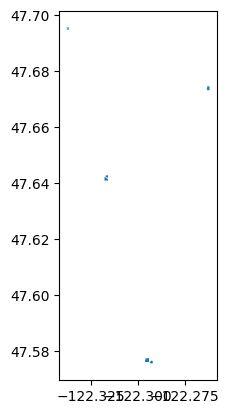

In [ ]:
schoolBoston[(schoolBoston.element=='relation') & (schoolBoston.geometry.geom_type=='MultiPolygon')].plot()

In [ ]:
base=seattle.explore(tiles='cartodbpositron',color='lightblue')
schoolSeattle.explore(m=base,color='k')
fuelSeattle.explore(m=base,color='red')

**PASO 3:** Obtenemos las estaciones de Gas


In [ ]:
# Get gas stations in Seattle
import osmnx as ox

stations = ox.features_from_place("Seattle, WA, USA",
                                tags={'amenity': 'fuel'})

In [ ]:
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 129 entries, ('node', np.int64(457773031)) to ('way', np.int64(1106778201))
Data columns (total 70 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   geometry                   129 non-null    geometry
 1   amenity                    129 non-null    object  
 2   brand                      112 non-null    object  
 3   brand:wikidata             110 non-null    object  
 4   name                       120 non-null    object  
 5   addr:city                  42 non-null     object  
 6   addr:housenumber           46 non-null     object  
 7   addr:postcode              43 non-null     object  
 8   addr:street                46 non-null     object  
 9   check_date                 47 non-null     object  
 10  compressed_air             49 non-null     object  
 11  website                    33 non-null     object  
 12  source                     79 

OSM gave you stations unprojected:

In [ ]:
stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Notice the multi-index:

In [ ]:
stations

geometry amenity  \
element id                                                                      
node    457773031                         POINT (-122.39997 47.63939)    fuel   
        631386821                          POINT (-122.3203 47.62518)    fuel   
        678256779                         POINT (-122.29762 47.57811)    fuel   
        771801423                         POINT (-122.35525 47.73205)    fuel   
        1197964284                        POINT (-122.32958 47.58001)    fuel   
...                                                               ...     ...   
way     616232166   POLYGON ((-122.29764 47.57818, -122.29764 47.5...    fuel   
        616232167   POLYGON ((-122.29757 47.57809, -122.29749 47.5...    fuel   
        727276570   POLYGON ((-122.33603 47.53219, -122.33603 47.5...    fuel   
        940949039   POLYGON ((-122.26383 47.68144, -122.26394 47.6...    fuel   
        1106778201  POLYGON ((-122.30916 47.57672, -122.30956 47.5...    fuel   

                       brand brand:wikidata              name addr:city  \
element id                                                                
node    457773031    Chevron        Q319642  Magnolia Chevron       NaN   
        631386821         76       Q1658320                76   Seattle   
        678256779       Arco        Q304769              Arco       NaN   
        771801423    Chevron        Q319642           Chevron       NaN   
        1197964284     Shell     Q110716465             Shell       NaN   
...                      ...            ...               ...       ...   
way     616232166        NaN            NaN               NaN       NaN   
        616232167        NaN            NaN               NaN       NaN   
        727276570      Shell     Q110716465           Shree's   Seattle   
        940949039   7-Eleven        Q259340          7-Eleven       NaN   
        1106778201  Sinclair            NaN               NaN       NaN   

                   addr:housenumber addr:postcode              addr:street  \
element id                                                                   
node    457773031               NaN           NaN                      NaN   
        631386821               915         98102          East Roy Street   
        678256779               NaN           NaN                      NaN   
        771801423               NaN           NaN                      NaN   
        1197964284              NaN           NaN                      NaN   
...                             ...           ...                      ...   
way     616232166               NaN           NaN                      NaN   
        616232167               NaN           NaN                      NaN   
        727276570               140         98106  Southwest Kenyon Street   
        940949039               NaN           NaN                      NaN   
        1106778201              NaN           NaN                      NaN   

                    check_date  ... contact:facebook contact:instagram  \
element id                      ...                                      
node    457773031          NaN  ...              NaN               NaN   
        631386821   2024-08-13  ...              NaN               NaN   
        678256779          NaN  ...              NaN               NaN   
        771801423          NaN  ...              NaN               NaN   
        1197964284         NaN  ...              NaN               NaN   
...                        ...  ...              ...               ...   
way     616232166          NaN  ...              NaN               NaN   
        616232167          NaN  ...              NaN               NaN   
        727276570          NaN  ...              NaN               NaN   
        940949039          NaN  ...              NaN               NaN   
        1106778201         NaN  ...              NaN               NaN   

                   contact:phone contact:twitter cont

In the multi index you see **nodes**, and **ways**:

In [ ]:
stations.index

MultiIndex([('node',  457773031),
            ('node',  631386821),
            ('node',  678256779),
            ('node',  771801423),
            ('node', 1197964284),
            ('node', 1489962206),
            ('node', 1731281907),
            ('node', 2702032640),
            ('node', 2702054487),
            ('node', 2995124967),
            ...
            ( 'way',  600101678),
            ( 'way',  600101691),
            ( 'way',  600101760),
            ( 'way',  603557992),
            ( 'way',  616232144),
            ( 'way',  616232166),
            ( 'way',  616232167),
            ( 'way',  727276570),
            ( 'way',  940949039),
            ( 'way', 1106778201)],
           names=['element', 'id'], length=129)

Vemos que no hay element

In [ ]:
stations.reset_index(drop=False,inplace=True)
stations.head()

element          id                     geometry amenity    brand  \
0    node   457773031  POINT (-122.39997 47.63939)    fuel  Chevron   
1    node   631386821   POINT (-122.3203 47.62518)    fuel       76   
2    node   678256779  POINT (-122.29762 47.57811)    fuel     Arco   
3    node   771801423  POINT (-122.35525 47.73205)    fuel  Chevron   
4    node  1197964284  POINT (-122.32958 47.58001)    fuel    Shell   

  brand:wikidata              name addr:city addr:housenumber addr:postcode  \
0        Q319642  Magnolia Chevron       NaN              NaN           NaN   
1       Q1658320                76   Seattle              915         98102   
2        Q304769              Arco       NaN              NaN           NaN   
3        Q319642           Chevron       NaN              NaN           NaN   
4     Q110716465             Shell       NaN              NaN           NaN   

   ... contact:facebook contact:instagram contact:phone contact:twitter  \
0  ...              NaN               NaN           NaN             NaN   
1  ...              NaN               NaN           NaN             NaN   
2  ...              NaN               NaN           NaN             NaN   
3  ...              NaN               NaN           NaN             NaN   
4  ...              NaN               NaN           NaN             NaN   

  contact:youtube covered shop landuse contact:website mapwithai:source  
0             NaN     NaN  NaN     NaN             NaN              NaN  
1             NaN     NaN  NaN     NaN             NaN              NaN  
2             NaN     NaN  NaN     NaN             NaN              NaN  
3             NaN     NaN  NaN     NaN             NaN              NaN  
4             NaN     NaN  NaN     NaN             NaN              NaN  

[5 rows x 72 columns]

- Keep some columns:

In [ ]:
colsToKeep=['element','name','geometry']
fuelSeattle=stations[colsToKeep].copy()

- Reproject the data:

In [ ]:
Seattle_crs = "EPSG:26986"

fuelSeattle = fuelSeattle.to_crs(Seattle_crs)

- Review:

In [ ]:
fuelSeattle.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   element   129 non-null    object  
 1   name      120 non-null    object  
 2   geometry  129 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 3.2+ KB


- From above, columns **name** of the gas station has missing values. We should rename those missing values:

In [ ]:
fuelSeattle.fillna({'name':'Unknown'},inplace=True)

- We usually use the names as row index. But row index should not have duplicates. Since several 'names' are the same (_Unknown_), we have to create new names:

In [ ]:
fuelSeattle.index.astype(str)+"_"+fuelSeattle.name

0      0_Magnolia Chevron
1                    1_76
2                  2_Arco
3               3_Chevron
4                 4_Shell
              ...        
124           124_Unknown
125           125_Unknown
126           126_Shree's
127          127_7-Eleven
128           128_Unknown
Length: 129, dtype: object

Then,

In [ ]:
fuelSeattle['newname']=fuelSeattle.index.astype(str)+"_"+fuelSeattle.name
fuelSeattle.set_index('newname',inplace=True)
fuelSeattle.drop(columns=['name'],inplace=True)
fuelSeattle.head()

element                          geometry
newname                                                     
0_Magnolia Chevron    node  POINT (-3418433.356 2601533.031)
1_76                  node   POINT (-3414347.628 2596842.39)
2_Arco                node   POINT (-3415878.252 2591529.61)
3_Chevron             node  POINT (-3409828.147 2608202.203)
4_Shell               node   POINT (-3417759.099 2593059.87)

See that **nodes** are points, **ways** are lines or simple shapes built from points, and **relations** are conceptual containers that group any of the other elements to represent complex features.

Let me compare with the geometries available:


In [ ]:
import pandas as pd

pd.crosstab(fuelSeattle.element,fuelSeattle.geometry.geom_type, margins=True)


col_0    Point  Polygon  All
element                     
node        15        0   15
way          0      114  114
All         15      114  129

In [ ]:
#original data
stations[stations.element=='node']

element           id                     geometry amenity     brand  \
0     node    457773031  POINT (-122.39997 47.63939)    fuel   Chevron   
1     node    631386821   POINT (-122.3203 47.62518)    fuel        76   
2     node    678256779  POINT (-122.29762 47.57811)    fuel      Arco   
3     node    771801423  POINT (-122.35525 47.73205)    fuel   Chevron   
4     node   1197964284  POINT (-122.32958 47.58001)    fuel     Shell   
5     node   1489962206  POINT (-122.32805 47.66483)    fuel  7-Eleven   
6     node   1731281907  POINT (-122.39183 47.62784)    fuel       NaN   
7     node   2702032640  POINT (-122.34533 47.64521)    fuel       NaN   
8     node   2702054487  POINT (-122.40835 47.68045)    fuel       NaN   
9     node   2995124967  POINT (-122.36928 47.66526)    fuel       NaN   
10    node   5283345524   POINT (-122.3241 47.60604)    fuel        76   
11    node   6329916588   POINT (-122.37236 47.6967)    fuel     Mobil   
12    node   8018977320  POINT (-122.27356 47.66824)    fuel        76   
13    node  10856272251  POINT (-122.28538 47.54633)    fuel   Chevron   
14    node  11648398007  POINT (-122.36025 47.52265)    fuel       NaN   

   brand:wikidata                          name addr:city addr:housenumber  \
0         Q319642              Magnolia Chevron       NaN              NaN   
1        Q1658320                            76   Seattle              915   
2         Q304769                          Arco       NaN              NaN   
3         Q319642                       Chevron       NaN              NaN   
4      Q110716465                         Shell       NaN              NaN   
5         Q259340                      7-Eleven       NaN              NaN   
6             NaN                           NaN       NaN              NaN   
7             NaN  Morrison's North Star Marine   Seattle             2732   
8             NaN           Shilshole Fuel Dock   Seattle             7029   
9             NaN           Dr. Dan's Biodiesel   Seattle              912   
10       Q1658320                            76       NaN              914   
11     Q109676002                         Mobil       NaN              NaN   
12       Q1658320                            76       NaN              NaN   
13        Q319642                       Chevron       NaN              NaN   
14            NaN             Gas & Smoke Depot   Seattle             9001   

   addr:postcode  ... contact:facebook contact:instagram contact:phone  \
0            NaN  ...              NaN               NaN           NaN   
1          98102  ...              NaN               NaN           NaN   
2            NaN  ...              NaN               NaN           NaN   
3            NaN  ...              NaN               NaN           NaN   
4            NaN  ...              NaN               NaN           NaN   
5            NaN  ...              NaN               NaN           NaN   
6            NaN  ...              NaN               NaN           NaN   
7          98109  ...              NaN               NaN           NaN   
8          98117  ...              NaN               NaN           NaN   
9          98107  ...              NaN               NaN           NaN   
10           NaN  ...              NaN               NaN           NaN   
11           NaN  ...              NaN               NaN           NaN   
12           NaN  ...              NaN               NaN           NaN   
13           NaN  ...              NaN               NaN           NaN   
14         98106  ...              NaN               NaN           NaN   

   contact:twitter contact:youtube covered shop landuse contact:website  \
0              NaN             NaN     NaN  NaN     NaN             NaN   
1              NaN             NaN     NaN  NaN     NaN             NaN   
2              NaN             NaN     NaN  NaN     NaN             NaN   
3              NaN             NaN     NaN  NaN     NaN             NaN   
4        

<Axes: >

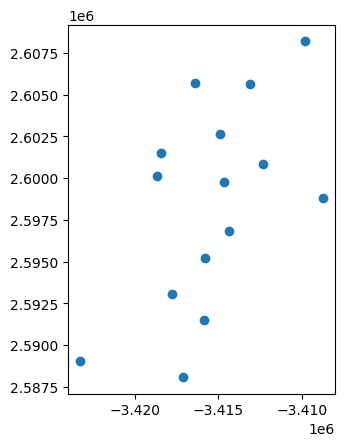

In [ ]:
fuelSeattle[fuelSeattle.element=='node'].plot()

# Explore proximity:


Let's compute a couple of distance matrices.

- The distance among fuel stations

In [ ]:
D_Matrix_fuel_fuel=fuelSeattle.geometry.apply\
(lambda station: fuelSeattle.geometry.distance(station))

display(D_Matrix_fuel_fuel)

newname             0_Magnolia Chevron          1_76        2_Arco  \
newname                                                              
0_Magnolia Chevron            0.000000   6220.554099  10324.582097   
1_76                       6220.554099      0.000000   5528.872812   
2_Arco                    10324.582097   5528.872812      0.000000   
3_Chevron                 10887.033167  12225.836684  17736.378954   
4_Shell                    8499.945887   5093.681033   2424.723390   
...                                ...           ...           ...   
124_Unknown               10315.202317   5516.870368      7.099370   
125_Unknown               10324.315629   5532.504505      3.953940   
126_Shree's               12902.287965  10441.672657   5874.123785   
127_7-Eleven              11285.835470   7582.455939  11810.286283   
128_Unknown                9752.517231   5450.222289    886.653611   

newname                3_Chevron       4_Shell    5_7-Eleven     6_Unknown  \
newname                                                                      
0_Magnolia Chevron  10887.033167   8499.945887   6126.887639   1428.541426   
1_76                12225.836684   5093.681033   4466.978042   5408.955375   
2_Arco              17736.378954   2424.723390   9954.027706   9027.306267   
3_Chevron               0.000000  17093.573647   7784.779563  11963.529742   
4_Shell             17093.573647      0.000000   9474.494849   7117.037069   
...                          ...           ...           ...           ...   
124_Unknown         17724.274167   2421.814140   9941.908106   9018.423945   
125_Unknown         17739.821503   2418.041271   9957.427498   9026.367212   
126_Shree's         22362.130865   5351.430728  14816.454563  11476.689553   
127_7-Eleven         8908.975534  12359.205243   5177.987360  11354.100925   
128_Unknown         17666.650353   1535.715486   9916.914433   8413.347235   

newname             7_Morrison's North Star Marine  8_Shilshole Fuel Dock  \
newname                                                                     
0_Magnolia Chevron                     4175.363863            4630.333278   
1_76                                   2928.317828            9070.258407   
2_Arco                                 8315.199170           14161.611195   
3_Chevron                              9729.863650            7018.213672   
4_Shell                                7378.902867           12697.804582   
...                                            ...                    ...   
124_Unknown                            8303.557115           14150.798491   
125_Unknown                            8319.152598           14163.668178   
126_Shree's                           12633.504605           17428.671560   
127_7-Eleven                           7351.206360           10893.940431   
128_Unknown                            8087.855879           13753.391562   

newname             9_Dr. Dan's Biodiesel  ...   119_Chevron        120_76  \
newname                                    ...                               
0_Magnolia Chevron            3703.378442  ...  11088.484563   8099.731946   
1_76                          5805.722146  ...  10555.085449   9330.267750   
2_Arco                       11136.349795  ...  15841.352200  14857.625726   
3_Chevron                     7536.285098  ...   3452.365972   2976.865976   
4_Shell                       9982.541386  ...  15635.493525  14129.426502   
...                                   ...  ...           ...           ...   
124_Unknown                  11124.934054  ...  15829.239100  14845.589559   
125_Unknown                  11139.712236  ...  15844.240342  14861.206847   
126_Shree's                  15064.206986  ...  20986.797812  19382.235254   
127_7-Eleven                  8148.901121  ...   5645.757718   7380.228019   
128_Unknown                  10843.265329  ...  15935.431728  14747.145190   

newname              121_Chevron  122_Safeway Fuel Statio

From here, we can compute the minimal distance among those gas stations:

In [ ]:
D_Matrix_fuel_fuel.replace(0,None,inplace=True) # avoid the zero
D_Matrix_fuel_fuel.min(axis=1).sort_values().head(10)

newname
103_ARCO        3.595886
102_ARCO        3.595886
125_Unknown      3.95394
2_Arco           3.95394
88_76           4.489809
87_76           4.489809
124_Unknown      7.09937
89_Shell       10.573901
90_Shell       10.573901
60_Gull        12.488653
dtype: object

- The distance among gas stations and schools:

In [ ]:
D_Matrix_fuel_school=fuelSeattle.geometry.apply\
(lambda station: schoolSeattle.geometry.distance(station))

display(D_Matrix_fuel_school)

newname             0_Mapleleaf School  1_Hazel Wolf K-8  2_Epic Life Academy  \
newname                                                                         
0_Magnolia Chevron        10544.512155       7235.207545          8582.237895   
1_76                       8729.239043       5818.822543          9094.944283   
2_Arco                    13768.839820      11228.002421         14591.103003   
3_Chevron                  5717.088197       6609.323266          3158.933380   
4_Shell                   13810.972485      10876.652858         14026.656537   
...                                ...               ...                  ...   
124_Unknown               13756.614033      11215.848097         14578.980131   
125_Unknown               13771.403195      11231.196584         14594.491954   
126_Shree's               19140.832592      16225.844783         19333.495328   
127_7-Eleven               3207.540037       4418.269146          6434.611949   
128_Unknown               13946.303526      11248.095235         14543.547231   

newname             3_Christ the King Elementary School  \
newname                                                   
0_Magnolia Chevron                          9001.896399   
1_76                                       10175.510352   
2_Arco                                     15695.827417   
3_Chevron                                   2075.728667   
4_Shell                                    15019.635369   
...                                                 ...   
124_Unknown                                15683.750926   
125_Unknown                                15699.335467   
126_Shree's                                20286.511009   
127_7-Eleven                                7625.696833   
128_Unknown                                15608.103194   

newname             4_Assumption Saint Bridget School  \
newname                                                 
0_Magnolia Chevron                        8977.309995   
1_76                                      5883.026249   
2_Arco                                   10771.696415   
3_Chevron                                 7961.528850   
4_Shell                                  10910.666228   
...                                               ...   
124_Unknown                              10759.391908   
125_Unknown                              10774.200983   
126_Shree's                              16210.670896   
127_7-Eleven                              2320.583017   
128_Unknown                              10970.417726   

newname             5_Saint Edward Parish School  6_Learning Way School  \
newname                                                                   
0_Magnolia Chevron                  13407.409505           13573.676255   
1_76                                 8851.691507           12034.017838   
2_Arco                               3330.412312            7954.269222   
3_Chevron                           21033.975581           23591.186559   
4_Shell                              4954.069047            6998.894859   
...                                          ...                    ...   
124_Unknown                          3334.946554            7958.877055   
125_Unknown                          3314.222683            7938.000547   
126_Shree's                          4655.798653            2223.106569   
127_7-Eleven                        14653.387126           19345.581018   
128_Unknown                          3631.619598            7307.085865   

newname             7_Concordia Lutheran School  \
newname                                           
0_Magnolia Chevron                  9553.974110   
1_76                                6632.635515   
2_Arco                             11475.215546   
3_Chevron                           7602.271452   
4_Shell                            11653.694770   
...                                         ...   
124_Unknown                        11462.799663   
1

# Decision 1: Find the stations that should go away



Now, we could compute the minimal distance from a gas station to a school, and sort the stations by that value:

In [ ]:
D_Matrix_fuel_school.min(axis=1).sort_values().head(10)

newname
101_Shell        0.828757
37_Shell        23.376028
68_Shell        36.827289
1_76            75.444304
111_Chevron     91.671685
73_Shell        95.097816
109_Shell       97.540781
95_Chevron     100.495328
35_Chevron     112.617874
23_Arco        124.564777
dtype: float64

**PASO 4: ** Identique que estaciones estan al menos 200 metros de algun centro educativo.

In [ ]:
mindDist=200

# Decision 2: Secure perimeter of every school

Let's create the safe area around the school. This requires **buffer**:

In [ ]:
schoolSeattle_buffered=schoolSeattle.buffer(mindDist)
schoolSeattle_buffered

newname
0_Mapleleaf School                          POLYGON ((-3407764.905 2602797.259, -3407765.8...
1_Hazel Wolf K-8                            POLYGON ((-3411001.026 2601737.039, -3411001.9...
2_Epic Life Academy                         POLYGON ((-3410451.7 2605152.512, -3410452.664...
3_Christ the King Elementary School         POLYGON ((-3410662.072 2606402.301, -3410663.0...
4_Assumption Saint Bridget School           POLYGON ((-3409348.844 2600245.575, -3409349.8...
                                                                  ...                        
205_Little Laurels                          POLYGON ((-3406629.125 2604602.802, -3406617.2...
206_Cascade Parent Partnership Program      POLYGON ((-3415331.219 2600670.87, -3415245.75...
207_Roxhill Elementary School               POLYGON ((-3424086.667 2588854.312, -3424093.4...
208_Downtown School                         POLYGON ((-3416619.304 2597958.438, -3416603.6...
209_Seattle Waldorf School - Main Campus    POLYGON ((-3408035.065 2603158.588, -3407970.0...
Length: 210, dtype: geometry

In [ ]:
#remember we have
type(schoolSeattle_buffered)

geopandas.geoseries.GeoSeries

Turning GS into GDF:

In [ ]:
secured_schoolSeattle=gpd.GeoDataFrame(geometry=schoolSeattle_buffered)
secured_schoolSeattle

geometry
newname                                                                                    
0_Mapleleaf School                        POLYGON ((-3407764.905 2602797.259, -3407765.8...
1_Hazel Wolf K-8                          POLYGON ((-3411001.026 2601737.039, -3411001.9...
2_Epic Life Academy                       POLYGON ((-3410451.7 2605152.512, -3410452.664...
3_Christ the King Elementary School       POLYGON ((-3410662.072 2606402.301, -3410663.0...
4_Assumption Saint Bridget School         POLYGON ((-3409348.844 2600245.575, -3409349.8...
...                                                                                     ...
205_Little Laurels                        POLYGON ((-3406629.125 2604602.802, -3406617.2...
206_Cascade Parent Partnership Program    POLYGON ((-3415331.219 2600670.87, -3415245.75...
207_Roxhill Elementary School             POLYGON ((-3424086.667 2588854.312, -3424093.4...
208_Downtown School                       POLYGON ((-3416619.304 2597958.438, -3416603.6...
209_Seattle Waldorf School - Main Campus  POLYGON ((-3408035.065 2603158.588, -3407970.0...

[210 rows x 1 columns]

Buffers created polygons:

In [ ]:
secured_schoolSeattle.geometry.geom_type.value_counts()

Polygon    210
Name: count, dtype: int64

# Decision 3: Standardized Gas stations geometries

Not all gas stations are points:

In [ ]:
fuelSeattle.geometry.geom_type.value_counts()

Polygon    114
Point       15
Name: count, dtype: int64

The point is a simple representation. Then let's make a buffer of 10 meters for every station to make sure the station is selected even if we just had one of its points.

In [ ]:
fuelSeattle_allPoly=fuelSeattle.copy()
fuelSeattle_allPoly['geometry'] = [
    station.buffer(10) if station.geom_type == 'Point' else station
    for station in fuelSeattle.geometry
]

In [ ]:
# rechecking
fuelSeattle_allPoly.geometry.geom_type.value_counts()

Polygon    129
Name: count, dtype: int64

# Decision 4: Overlay or SJoin to determine gas stations in trouble

This is great moment to test our understanding of these ops:

- do you want to move the points from the gas stations that are close to the schools?

In [ ]:
fuelSeattle_allPoly.overlay(secured_schoolSeattle,how='intersection',keep_geom_type=False)

element                                           geometry
0     node  POLYGON ((-3414337.676 2596841.41, -3414337.82...
1     node  POLYGON ((-3414337.676 2596841.41, -3414337.82...
2     node  POLYGON ((-3415868.3 2591528.63, -3415868.444 ...
3     node  POLYGON ((-3417749.147 2593058.89, -3417749.29...
4     node  POLYGON ((-3417093.34 2588071.53, -3417093.484...
5     node  POLYGON ((-3423265.952 2589055.057, -3423266.6...
6      way  POLYGON ((-3410821.239 2605250.071, -3410824.7...
7      way  POLYGON ((-3421146.076 2595479.866, -3421153.1...
8      way  POLYGON ((-3414365.01 2594480.265, -3414371.51...
9      way  POLYGON ((-3414365.01 2594480.265, -3414371.51...
10     way  POLYGON ((-3415529.579 2604186.561, -3415523.3...
11     way  POLYGON ((-3413392.305 2605592.076, -3413380.7...
12     way  POLYGON ((-3408940.404 2600787.3, -3408933.371...
13     way  POLYGON ((-3409497.63 2601335.933, -3409491.16...
14     way  POLYGON ((-3410406.363 2602997.839, -3410408.5...
15     way  POLYGON ((-3417764.462 2593060.862, -3417761.4...
16     way  POLYGON ((-3414292.018 2595503.512, -3414296.2...
17     way  POLYGON ((-3414292.018 2595503.512, -3414296.2...
18     way  POLYGON ((-3414292.018 2595503.512, -3414296.2...
19     way  POLYGON ((-3415359.264 2594929.138, -3415353.8...
20     way  POLYGON ((-3414469.191 2595566.625, -3414469.6...
21     way  POLYGON ((-3414469.191 2595566.625, -3414469.6...
22     way  POLYGON ((-3422151.856 2593512.179, -3422153.7...
23     way  MULTIPOLYGON (((-3416988.025 2597789.695, -341...
24     way  POLYGON ((-3416515.765 2587670.61, -3416509.59...
25     way  POLYGON ((-3421241.141 2595616.668, -3421253.2...
26     way  POLYGON ((-3416061.353 2589716.521, -3416063.5...
27     way  POLYGON ((-3416061.353 2589716.521, -3416091.8...
28     way  POLYGON ((-3422326.309 2590508.718, -3422338.5...
29     way  POLYGON ((-3421109.228 2595507.372, -3421100.5...
30     way  POLYGON ((-3413257.497 2601001.607, -3413301.1...
31     way  POLYGON ((-3423553.179 2590793.599, -3423562.0...
32     way  POLYGON ((-3415873.087 2591540.613, -3415867.0...
33     way  POLYGON ((-3415878.043 2591513.604, -3415884.5...

- do you want to move the gas stations that are close to the schools?

In [ ]:
fuelSeattle_allPoly.sjoin(secured_schoolSeattle,how='inner',predicate='intersects')

element  \
newname_left                   
1_76                    node   
1_76                    node   
2_Arco                  node   
4_Shell                 node   
13_Chevron              node   
14_Gas & Smoke Depot    node   
17_Arco                  way   
19_Safeway               way   
23_Arco                  way   
23_Arco                  way   
29_7-Eleven              way   
33_Chevron               way   
35_Chevron               way   
37_Shell                 way   
38_Chevron               way   
61_Shell                 way   
68_Shell                 way   
68_Shell                 way   
68_Shell                 way   
70_Chevron               way   
71_7-Eleven              way   
71_7-Eleven              way   
73_Shell                 way   
83_Shell                 way   
86_76                    way   
95_Chevron               way   
101_Shell                way   
101_Shell                way   
105_Unknown              way   
107_Chevron              way   
109_Shell                way   
111_Chevron              way   
124_Unknown              way   
125_Unknown              way   

                                                               geometry  \
newname_left                                                              
1_76                  POLYGON ((-3414337.628 2596842.39, -3414337.67...   
1_76                  POLYGON ((-3414337.628 2596842.39, -3414337.67...   
2_Arco                POLYGON ((-3415868.252 2591529.61, -3415868.3 ...   
4_Shell               POLYGON ((-3417749.099 2593059.87, -3417749.14...   
13_Chevron            POLYGON ((-3417093.292 2588072.51, -3417093.34...   
14_Gas & Smoke Depot  POLYGON ((-3423263.682 2589061.401, -3423263.7...   
17_Arco               POLYGON ((-3410811.122 2605265.495, -3410821.2...   
19_Safeway            POLYGON ((-3421137.097 2595493.222, -3421146.0...   
23_Arco               POLYGON ((-3414359.502 2594488.58, -3414365.01...   
23_Arco               POLYGON ((-3414359.502 2594488.58, -3414365.01...   
29_7-Eleven           POLYGON ((-3415533.131 2604181.358, -3415529.5...   
33_Chevron            POLYGON ((-3413389.56 2605575.751, -3413392.30...   
35_Chevron            POLYGON ((-3408947.779 2600776.011, -3408940.4...   
37_Shell              POLYGON ((-3409501.57 2601338.522, -3409497.63...   
38_Chevron            POLYGON ((-3410401.925 2602994.789, -3410406.3...   
61_Shell              POLYGON ((-3417765.189 2593059.884, -3417764.4...   
68_Shell              POLYGON ((-3414288.508 2595503.292, -3414292.0...   
68_Shell              POLYGON ((-3414288.508 2595503.292, -3414292.0...   
68_Shell              POLYGON ((-3414288.508 2595503.292, -3414292.0...   
70_Chevron            POLYGON ((-3415365.501 2594919.737, -3415359.2...   
71_7-Eleven           POLYGON ((-3414476.716 2595567.099, -3414469.1...   
71_7-Eleven           POLYGON ((-3414476.716 2595567.099, -3414469.1...   
73_Shell              POLYGON ((-3422136.913 2593516.045, -3422151.8...   
83_Shell              POLYGON ((-3416985.504 2597793.302, -3416988.0...   
86_76                 POLYGON ((-3416519.849 2587656.624, -3416515.7...   
95_Chevron            POLYGON ((-3421234.992 2595625.614, -3421241.1...   
101_Shell             POLYGON ((-3416043.695 2589742.829, -3416061.3...   
101_Shell             POLYGON ((-3416043.695 2589742.829, -3416061.3...   
105_Unknown           POLYGON ((-3422312.127 2590526.045, -3422326.3...   
107_Chevron           POLYGON ((-3421089.504 2595512.878, -3421098.3...   
109_Shell             POLYGON ((-3413240.378 2601027.086, -3413257.4...   
111_Chevron           POLYGON ((-3423547.257 2590802.064, -3423553.1...   
124_Unknown           POLYGON ((-3415875.781 2591536.476, -3415873.0...   
125_Unknown           POLYGON ((-3415876.69 2591525.381, -3415878.04...   

                                                   newname_right  
newname_left                                                      
1_76                             

The obvious choice is using **sjoin** + **intersects** (why not within?).

In [ ]:
gas_relocate=fuelSeattle_allPoly.sjoin(secured_schoolSeattle,how='inner',predicate='intersects')

It is possible the index may have duplicates:

In [ ]:
is_duplicate = gas_relocate.index.duplicated(keep=False)

gas_relocate[is_duplicate]

Empty GeoDataFrame
Columns: [element, geometry, newname_right]
Index: []

Remember our names are on the row index, then:

In [ ]:
# put the index as a column: reset_index(drop=False)
# drop duplicates in that column:drop_duplicates(subset='newname_left')
# column bask to index : set_index('newname_left')

gas_relocate.reset_index(drop=False).\
drop_duplicates(subset='newname_left').\
set_index('newname_left')

element  \
newname_left                   
1_76                    node   
2_Arco                  node   
4_Shell                 node   
13_Chevron              node   
14_Gas & Smoke Depot    node   
17_Arco                  way   
19_Safeway               way   
23_Arco                  way   
29_7-Eleven              way   
33_Chevron               way   
35_Chevron               way   
37_Shell                 way   
38_Chevron               way   
61_Shell                 way   
68_Shell                 way   
70_Chevron               way   
71_7-Eleven              way   
73_Shell                 way   
83_Shell                 way   
86_76                    way   
95_Chevron               way   
101_Shell                way   
105_Unknown              way   
107_Chevron              way   
109_Shell                way   
111_Chevron              way   
124_Unknown              way   
125_Unknown              way   

                                                               geometry  \
newname_left                                                              
1_76                  POLYGON ((-3414337.628 2596842.39, -3414337.67...   
2_Arco                POLYGON ((-3415868.252 2591529.61, -3415868.3 ...   
4_Shell               POLYGON ((-3417749.099 2593059.87, -3417749.14...   
13_Chevron            POLYGON ((-3417093.292 2588072.51, -3417093.34...   
14_Gas & Smoke Depot  POLYGON ((-3423263.682 2589061.401, -3423263.7...   
17_Arco               POLYGON ((-3410811.122 2605265.495, -3410821.2...   
19_Safeway            POLYGON ((-3421137.097 2595493.222, -3421146.0...   
23_Arco               POLYGON ((-3414359.502 2594488.58, -3414365.01...   
29_7-Eleven           POLYGON ((-3415533.131 2604181.358, -3415529.5...   
33_Chevron            POLYGON ((-3413389.56 2605575.751, -3413392.30...   
35_Chevron            POLYGON ((-3408947.779 2600776.011, -3408940.4...   
37_Shell              POLYGON ((-3409501.57 2601338.522, -3409497.63...   
38_Chevron            POLYGON ((-3410401.925 2602994.789, -3410406.3...   
61_Shell              POLYGON ((-3417765.189 2593059.884, -3417764.4...   
68_Shell              POLYGON ((-3414288.508 2595503.292, -3414292.0...   
70_Chevron            POLYGON ((-3415365.501 2594919.737, -3415359.2...   
71_7-Eleven           POLYGON ((-3414476.716 2595567.099, -3414469.1...   
73_Shell              POLYGON ((-3422136.913 2593516.045, -3422151.8...   
83_Shell              POLYGON ((-3416985.504 2597793.302, -3416988.0...   
86_76                 POLYGON ((-3416519.849 2587656.624, -3416515.7...   
95_Chevron            POLYGON ((-3421234.992 2595625.614, -3421241.1...   
101_Shell             POLYGON ((-3416043.695 2589742.829, -3416061.3...   
105_Unknown           POLYGON ((-3422312.127 2590526.045, -3422326.3...   
107_Chevron           POLYGON ((-3421089.504 2595512.878, -3421098.3...   
109_Shell             POLYGON ((-3413240.378 2601027.086, -3413257.4...   
111_Chevron           POLYGON ((-3423547.257 2590802.064, -3423553.1...   
124_Unknown           POLYGON ((-3415875.781 2591536.476, -3415873.0...   
125_Unknown           POLYGON ((-3415876.69 2591525.381, -3415878.04...   

                                                   newname_right  
newname_left                                                      
1_76                                147_Lowell Elementary School  
2_Arco                                   54_Franklin High School  
4_Shell                                    18_Career Link School  
13_Chevron                          163_Aki Kurose Middle School  
14_Gas & Smoke Depot                       6_Learning Way School  
17_Arco                                      2_Epic Life Academy  
19_Safeway                        98_Lafayette Elementary School  
23_Arco                                  76_Garfield High School  
29_7-Eleven                          134_Adams Elementary School  
33_Chevron                             193_Whitman Middle School  
35_Ch

In [ ]:
#making the actual change
gas_relocate= gas_relocate.reset_index(drop=False).drop_duplicates(subset='newname_left').\
              set_index('newname_left')

Let's see both schools and those stations to relocate:

In [ ]:
base=secured_schoolSeattle.sjoin(gas_relocate,how='inner',predicate='intersects').explore(color='yellow', tiles='cartodbpositron')
gas_relocate.explore(m=base,color='red')

**PASO 5:** Proponga una reubicación

In [ ]:
# Define the place
place = "Seattle, WA, USA"

# Download the street network graph for Boston
G = ox.graph_from_place(place, network_type="drive")

# Convert the graph edges (streets) to a GeoDataFrame
streets = ox.graph_to_gdfs(G, nodes=False, edges=True)

streets.shape

(50210, 15)

You see we got a huge set of routes:

In [ ]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 50210 entries, (np.int64(29445663), np.int64(335444348), np.int64(0)) to (np.int64(13246217556), np.int64(3705345449), np.int64(0))
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   osmid     50210 non-null  object  
 1   highway   50210 non-null  object  
 2   lanes     38684 non-null  object  
 3   maxspeed  49841 non-null  object  
 4   oneway    50210 non-null  bool    
 5   ref       756 non-null    object  
 6   reversed  50210 non-null  object  
 7   length    50210 non-null  float64 
 8   geometry  50210 non-null  geometry
 9   bridge    470 non-null    object  
 10  name      44823 non-null  object  
 11  tunnel    60 non-null     object  
 12  junction  4752 non-null   object  
 13  access    166 non-null    object  
 14  width     269 non-null    object  
dtypes: bool(1), float64(1), geometry(1), object(12)
memory usage: 6.9+ MB


Let's pay attention to the 'highway' column:

In [ ]:
streets.highway.value_counts().index

Index([                   'residential',                       'tertiary',
                            'secondary',                        'primary',
                         'unclassified',                  'motorway_link',
                             'motorway',                 'secondary_link',
                                'trunk',                   'primary_link',
                        'tertiary_link',                  'living_street',
        ['residential', 'unclassified'],                     'trunk_link',
                               'busway', ['residential', 'living_street'],
            ['residential', 'tertiary'],        ['secondary', 'tertiary'],
           ['tertiary', 'unclassified'],         ['secondary', 'primary'],
          ['motorway', 'motorway_link'],     ['primary', 'motorway_link'],
             ['trunk_link', 'tertiary'],      ['secondary', 'trunk_link'],
          ['trunk_link', 'residential'],    ['residential', 'trunk_link'],
         ['tertiary', 'se

In [ ]:
GAS_STATION_ROAD_TYPES = [
    'motorway',      # High-speed limited access roads
    'primary',       # Major national roads
    'trunk',         # Important regional roads
    'motorway_link', # Motorway entrance/exit ramps
    'primary_link',  # Primary road connectors
    'trunk_link',     # Trunk road connectors
    ['motorway', 'trunk'],
    ['primary', 'motorway_link'],
    ['primary', 'primary_link']
]

suitable_roads = streets[streets.highway.isin(GAS_STATION_ROAD_TYPES)]

suitable_roads.shape

(2428, 15)

Let's reproject:

In [ ]:
suitable_roads = suitable_roads.to_crs(seattle.crs)

In [ ]:
competitionDistance=10 # a safe value from above 'D_Matrix_fuel_fuel'
fuelSeattle_allPoly_buffered=fuelSeattle_allPoly.buffer(competitionDistance)

Do we have a GDF?

In [ ]:
type(fuelSeattle_allPoly_buffered)

geopandas.geoseries.GeoSeries

In [ ]:
secured_fuelSeattle_allPoly=gpd.GeoDataFrame(geometry=fuelSeattle_allPoly_buffered)


In [273]:
secured_areas_dissolved=secured_fuelSeattle_allPoly.overlay(secured_schoolSeattle,how='union',keep_geom_type=False).dissolve()
secured_areas=gpd.GeoDataFrame(geometry=secured_areas_dissolved.geometry)
secured_areas = secured_areas.to_crs(suitable_roads.crs) # Reproject secured_areas

- Filter the roads. We can NOT choose a location that intersects with the secured areas:

Choose: **overlay** vs **sjoin** vs **clip**?

<Axes: >

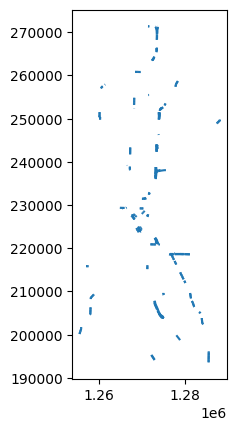

In [274]:
suitable_roads.clip(secured_areas,keep_geom_type=False).plot()

Let's visualize the suitable roads for gas stations (those outside the secured areas) and the proposed new locations.

<Axes: >

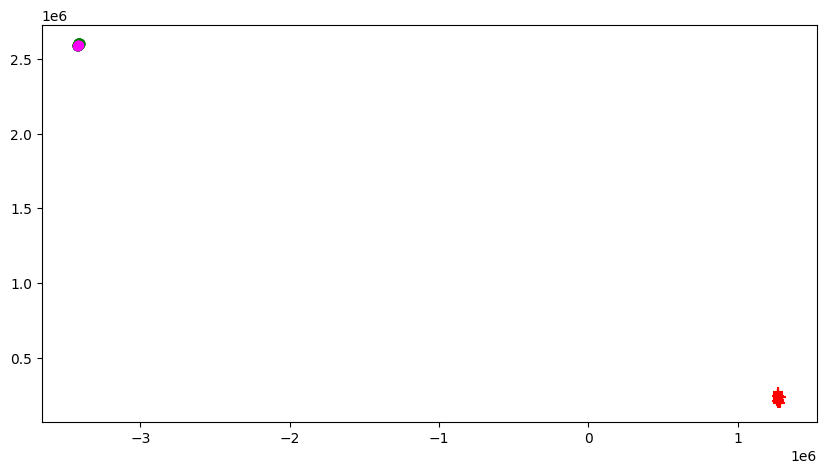

In [289]:
# original suitable roads
base = suitable_roads.plot(color='yellow', figsize=(10, 10),zorder=1)

# non-overlapping buffers
GoodLocationsGas_buffered_gdf.plot(ax=base, edgecolor='red', marker="+", facecolor='none',zorder=2)

# center points of the buffers
GoodLocationsGas_gdf.plot(ax=base, color='red', marker="+", markersize=50,zorder=3)

# all stations
fuelSeattle.plot(ax=base,color='k',zorder=4)
schoolSeattle.plot(ax=base,color='green',zorder=5)

# stations to relocate
fuelSeattle.clip(gas_relocate).plot(ax=base,color='magenta',zorder=5)

<Axes: >

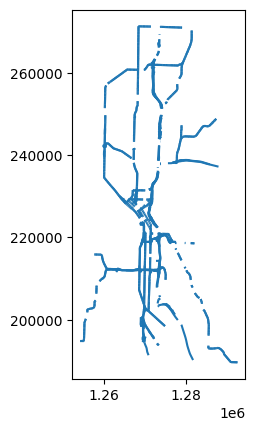

In [276]:
suitable_roads.overlay(secured_areas,keep_geom_type=False, how='difference').plot()

<Axes: >

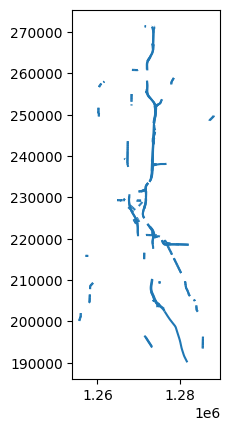

In [277]:
suitable_roads.sjoin(secured_areas, predicate='intersects').plot()

Este código calcula los segmentos de las carreteras principales que están fuera de las zonas seguras (escuelas y gasolineras).

In [278]:
good_routes_forGas_dissolved=suitable_roads.overlay(secured_areas,keep_geom_type=False, how='difference').dissolve()
good_routes_forGas=gpd.GeoDataFrame(geometry=good_routes_forGas_dissolved.geometry)
good_routes_forGas

geometry
0  MULTILINESTRING ((1273726.073 237808.907, 1273...

<Axes: >

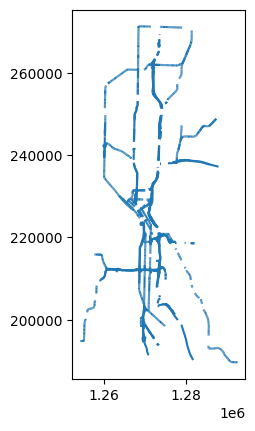

In [279]:
good_routes_forGas.plot()

We may choose a location from those places:

In [290]:
# newCOMPETITORS=safe_fuelCompetitors_gdf.copy()
potential_Locations=good_routes_forGas.copy()
newPOLYGONS=[]
pointsComputed=1
attempts=1
while pointsComputed<=len(gas_relocate):
  candidatePoint=potential_Locations.sample_points(1)
  candidateStation=gpd.GeoDataFrame(geometry=candidatePoint.buffer(100))
  if candidateStation.overlay(secured_areas,how='intersection',keep_geom_type=False).empty:
    newPOLYGONS.append(candidateStation)
    pointsComputed+=1
    potential_Locations=potential_Locations.overlay(candidateStation, how='difference', keep_geom_type=False)
  if attempts>len(gas_relocate)*100:
    break
  attempts+=1

# some info
attempts,len(newPOLYGONS)



(30, 28)

In [291]:
newPOLYGONS

[                                            geometry
 0  POLYGON ((1270013.677 210220.253, 1270013.195 ...,
                                             geometry
 0  POLYGON ((1260174.627 242334.886, 1260174.145 ...,
                                             geometry
 0  POLYGON ((1271472.906 218470.771, 1271472.424 ...,
                                             geometry
 0  POLYGON ((1273642.205 220572.507, 1273641.723 ...,
                                             geometry
 0  POLYGON ((1273516.619 266830.554, 1273516.137 ...,
                                             geometry
 0  POLYGON ((1278892.503 244495.274, 1278892.022 ...,
                                             geometry
 0  POLYGON ((1276238.485 219999.211, 1276238.003 ...,
                                             geometry
 0  POLYGON ((1273813.155 245688.091, 1273812.674 ...,
                                             geometry
 0  POLYGON ((1269910.44 220458.33, 1269909.958 22...,
                   

In [292]:
pd.concat(newPOLYGONS)

geometry
0  POLYGON ((1270013.677 210220.253, 1270013.195 ...
0  POLYGON ((1260174.627 242334.886, 1260174.145 ...
0  POLYGON ((1271472.906 218470.771, 1271472.424 ...
0  POLYGON ((1273642.205 220572.507, 1273641.723 ...
0  POLYGON ((1273516.619 266830.554, 1273516.137 ...
0  POLYGON ((1278892.503 244495.274, 1278892.022 ...
0  POLYGON ((1276238.485 219999.211, 1276238.003 ...
0  POLYGON ((1273813.155 245688.091, 1273812.674 ...
0  POLYGON ((1269910.44 220458.33, 1269909.958 22...
0  POLYGON ((1270211.261 212149.277, 1270210.779 ...
0  POLYGON ((1260205.846 238250.028, 1260205.364 ...
0  POLYGON ((1274594.137 198746.775, 1274593.656 ...
0  POLYGON ((1261897.48 232479.959, 1261896.999 2...
0  POLYGON ((1273895.87 245186.473, 1273895.389 2...
0  POLYGON ((1268766.176 225962.273, 1268765.694 ...
0  POLYGON ((1271770.553 229037.762, 1271770.072 ...
0  POLYGON ((1260391.517 255689.044, 1260391.035 ...
0  POLYGON ((1268774.265 211958.718, 1268773.783 ...
0  POLYGON ((1268434.806 262140.164, 1268434.324 ...
0  POLYGON ((1271165.196 226488.965, 1271164.714 ...
0  POLYGON ((1270286.981 218925.071, 1270286.5 21...
0  POLYGON ((1272085.63 256914.313, 1272085.148 2...
0  POLYGON ((1270771.782 229218.735, 1270771.3 22...
0  POLYGON ((1282997.819 205492.408, 1282997.338 ...
0  POLYGON ((1269906.761 203186.841, 1269906.28 2...
0  POLYGON ((1269945.03 206576.491, 1269944.549 2...
0  POLYGON ((1260344.128 245420.641, 1260343.647 ...
0  POLYGON ((1283267.964 245757.68, 1283267.482 2...

In [284]:
GoodLocationsGas_buffered_gdf=pd.concat(newPOLYGONS)
GoodLocationsGas_gdf=gpd.GeoDataFrame(geometry=GoodLocationsGas_buffered_gdf.centroid)

<Axes: >

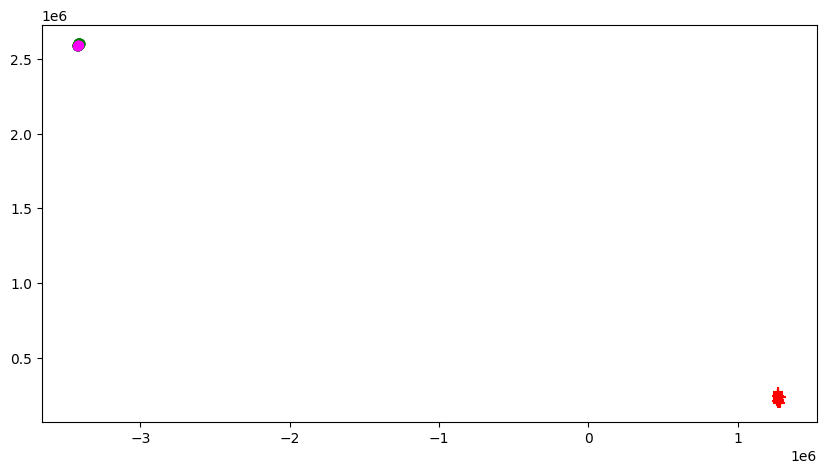

In [293]:
# original suitable roads
base = suitable_roads.plot(color='yellow', figsize=(10, 10),zorder=1)

# non-overlapping buffers
GoodLocationsGas_buffered_gdf.plot(ax=base, edgecolor='red', marker="+", facecolor='none',zorder=2)

# center points of the buffers
GoodLocationsGas_gdf.plot(ax=base, color='red', marker="+", markersize=50,zorder=3)

# all stations
fuelSeattle.plot(ax=base,color='k',zorder=4)
schoolSeattle.plot(ax=base,color='green',zorder=5)

# stations to relocate
fuelSeattle.clip(gas_relocate).plot(ax=base,color='magenta',zorder=5)


## Reverse geocoding

Just get some addresses:

In [294]:
from geopy.geocoders import Nominatim
import time

# Initialize geocoder
geolocator = Nominatim(user_agent="boston_gas_stations")

def get_address(point):
  # Now coordinates are in degrees (lon, lat)
  lon = point.x
  lat = point.y
  location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
  time.sleep(1)  # Rate limiting

  if location:
    return location.address
  else:
    return None # not found

In [295]:
# Get addresses
GoodLocationsGas_4326 = GoodLocationsGas_gdf.to_crs('EPSG:4326')
GoodLocationsGas_gdf['address'] = GoodLocationsGas_4326.geometry.apply(get_address)

In [288]:
GoodLocationsGas_gdf

geometry  \
0  POINT (1286010.378 237714.983)   
0  POINT (1267792.243 236373.616)   
0   POINT (1260089.198 242191.47)   
0  POINT (1278449.243 242612.562)   
0  POINT (1270083.928 218718.727)   
0  POINT (1268027.552 251883.688)   
0  POINT (1273187.113 220025.325)   
0  POINT (1280443.638 238805.838)   
0  POINT (1273540.704 213100.137)   
0  POINT (1269646.368 199933.997)   
0  POINT (1273319.315 239939.188)   
0    POINT (1273750.101 212325.2)   
0  POINT (1268390.346 268069.915)   
0  POINT (1268884.625 225591.065)   
0  POINT (1269994.232 213018.559)   
0   POINT (1271386.001 220379.58)   
0  POINT (1271697.833 231234.095)   
0   POINT (1263210.36 212239.589)   
0   POINT (1273473.486 218643.66)   
0    POINT (1268006.25 229284.84)   
0  POINT (1279695.295 196171.882)   
0  POINT (1266078.267 260887.498)   
0  POINT (1272078.591 259427.582)   
0  POINT (1269712.816 201264.361)   
0  POINT (1276532.955 202469.213)   
0  POINT (1265867.628 229062.787)   
0   POINT (1260200.967 242488.32)   
0  POINT (1271991.913 260089.622)   

                                             address  
0  Evergreen Point Floating Bridge, Seattle, King...  
0  2117, Aurora Avenue North, Fremont, Seattle, K...  
0  15th Avenue West & West Emerson Street, West E...  
0  University of Washington, Mary Gates Memorial ...  
0  1506, 1st Avenue South, Yesler Terrace, Seattl...  
0  7107, Aurora Avenue North, Phinney Ridge, Seat...  
0  I 90, Charles Street Complex (City of Seattle)...  
0  Evergreen Point Floating Bridge, Canterbury, M...  
0  I 5, Beacon Hill, Seattle, King County, Washin...  
0  West Marginal Way South, Georgetown, Seattle, ...  
0  Ship Canal Bridge, I 5, West Campus, Universit...  
0  West Seattle Bridge, Beacon Hill, Seattle, Kin...  
0  13241, Aurora Avenue North, Bitter Lake, Halle...  
0  State Route 99 Tunnel, South Lake Union, Casca...  
0  3300, 1st Avenue South, Seattle, King County, ...  
0  1000, 4th Avenue South, Yesler Terrace, Seattl...  
0  I 5 Express, Capitol Hill, Seattle, King Count...  
0  West Seattle Bridge, Youngstown, Seattle, King...  
0  I 5, Yesler Terrace, Seattle, King County, Was...  
0  Denny Way, South Lake Union, Cascade, Belltown...  
0  I 5, Seattle, King County, Washington, 98041, ...  
0  335, North 105th Street, Seattle, King County,...  
0  I 5, Licton Springs, Northgate, Seattle, King ...  
0  1st Avenue South Bridge, Georgetown, Seattle, ...  
0  6352, Swift Avenue South, Rainier Valley, Seat...  
0  Gallery Condominiums, 2911, 2nd Avenue, Uptown...  
0  15th Avenue West, Seattle, King County, Washin...  
0  I 5 Express, Licton Springs, Northgate, Seattl...

______

[BACK TO MAIN MENU](https://cienciadedatosespacial.github.io/GDF_OPS_applications/)